In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd 
from PIL import Image
import os   
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

## Part 1: A Practical Introduction to Bayesian Hyperparameter Optimization

### Problem Definition
Consider training a Multi-Layer Perceptron (MLP) like the one we trained for HW8. One training cycle can take longer than 2-3 minutes and often may far exceed on that depending on dataset size and the hyperparameters we set. 

From this we arrive at the problem that a grid search (one that checks all possible hyperparameters) is often completely infeasible. Let's say we exclude many hyperparameters and focus only on learning rate, number of neurons per hidden layer (assuming two hidden layers), and the activation function (as a categorical variable). Assuming we consider 4,000 values for the hidden layer size, 100 values for learning rate, and the 4 possible activation functions, we have a search space of size 1,600,000. Even assuming 1 minute per training cycle it'll take almost three years to check every possible combination, and that's with a limited search space!

This is the fundamental problem that we try to solve with Bayesian Optimization.

### Gaussian Process Model
Bayes theorem defines the probability of an event $A$ conditioned on an event $B$ as follows.

$$ P(A|B) = \frac{P(B | A) \ast P(A)}{P(B)} $$

Using this theorem, we arrive at the idea of a Gaussian Process (GP) model. Although the exact details are a little beyond the scope of this class, the idea is that we can model a complicated function by taking samples of the more complex function and creating a probability distribution over all possible functions that fit the data. Then as we take more samples we can continuously update our probability distribution to make our predictions more accurate.

### Bayesian Optimization
Bayesian Optimization is a strategy for optimizing expensive objective functions. It uses a surrogate model (like our GP model mentioned above) to approximate the objective function (score function) and an acquisition function to decide where to sample next. Instead of trying to find a perfect model of the whole sample space, the goal is to selectively sample areas with the highest chance of producing a global optimum. Let's get started with a demo by defining a simple objective function and instantiating a GP model.


In [6]:
# Define an expensive objective function that we want to approximate
def objective(x, noise=0.5):
    random_noise = np.random.normal(scale=noise)
    return (math.sin(5* math.pi * x) + x) + random_noise

# Generate initial samples with noise
X = np.random.random(10).reshape(-1, 1)
y = np.array([objective(x) for x in X]).reshape(-1, 1)

# Instantiate the model
gp_model = GaussianProcessRegressor()
gp_model.fit(X, y)

/var/folders/f1/tq0d32ns75nf17h55y1swtdh0000gn/T/ipykernel_82790/4076421521.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (math.sin(5* math.pi * x) + x) + random_noise


GaussianProcessRegressor()

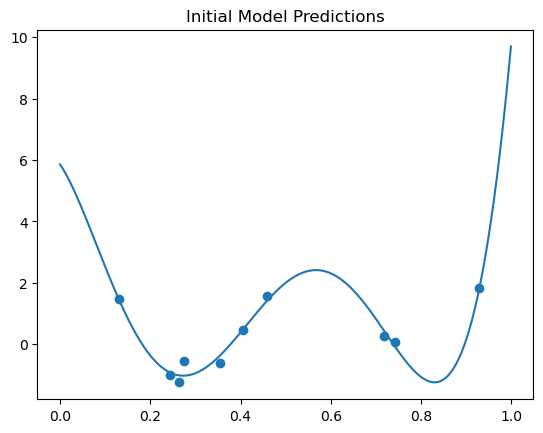

In [7]:
# Define a visualization function that plots prediction vs. actual
def visualize(X, y, model):
    plt.scatter(X, y)
    Xsamples = np.arange(0, 1, 0.001).reshape(-1, 1)
    ysamples = model.predict(Xsamples)
    plt.title("Initial Model Predictions")
    plt.plot(Xsamples, ysamples)
    plt.show()

# Visualize the initial data
visualize(X, y, gp_model)

### Acquisition Function
Now we have the problem of exploration vs exploitation, often observed in reinforcement learning problems such as bandit optimization. How can we choose points such that we optimize the balance between exploring unknown points that could potentially be better than what we have and verifying our current highest scores, especially in a non-deterministic sample space? This is where acquisition functions come in, they use various heuristic methods to determine what points are most likely to improve the model's predictions. Some of these methods include:

- Probability of Improvement
- Expected Improvement (EI): This function not only considers the probability of improvement but also takes into account the potential magnitude of improvement. It refines the approach by evaluating how much better a possible outcome could be.
- Entropy Search: This method selects points that will provide the most information gain, effectively balancing exploration across the sample space. It can be likened to traversing an extensive landscape of hills and valleys, seeking areas that offer the most insight.
- Upper Confidence Bound (UCB): UCB uses a balance factor to weigh between exploration and exploitation. It adjusts its strategy based on a confidence interval around predictions, allowing for a dynamic balance between trying new points and exploiting known high-value areas.

The technical workings of Entropy Search are a little complex and beyond the scope of the class, but let's talk about how we could implement the other three functions. 

### Probability of Improvement
Probability of Improvement (PI): This is the simplest acquisition function. It focuses on the probability that a given point will improve upon the current best-known value. 

To calculate the probability of improvement, we use the following formula:

$$PI(x) = \Phi\left(\frac{\mu(x) - f' - \xi}{\sigma(x)}\right)$$

Where:

- $\Phi$       is the cumulative distribution function (CDF) of the standard normal distribution.
- $\mu(x)$       is the predicted mean of the objective function at point $x$.
- $f'$     is the current best-known value of the objective function.
- $\xi$        is a small positive number that controls the trade-off between exploration and exploitation.
- $\sigma(x)$  is the predicted standard deviation of the objective function at point $x$.

The PI acquisition function is particularly useful when the objective function is noisy or when we have limited computational resources. However, due to its tendency to exploit known good regions excessively (as it doesn't take into account magnitude of improvement) it may miss out on exploring potentially better regions, leading to suboptimal solutions.

In practice, more sophisticated acquisition functions like Expected Improvement (EI) or Upper Confidence Bound (UCB) are often preferred as they balance exploration and exploitation more effectively.

In [8]:
# Implementation of the probability of improvement function
def probability_of_improvement(X, Xsamples, model, xi=0.01):
    # Determine the best score from the surrogate model so far
    yhat = model.predict(X)
    best_score = max(yhat)

    # Calculate mean and standard deviation using the surrogate model
    mu, std = model.predict(Xsamples, return_std=True)

    # Compute probability of improvement
    probabilities = norm.cdf((mu - best_score - xi) / (std + 1E-9))
    return probabilities

### Expected Improvement
Expected Improvement (EI): The Expected Improvement acquisition function is designed to select points that are expected to improve upon the best observed value so far. It balances exploration and exploitation by considering both the predicted mean and uncertainty at each point. The formula for EI is given by:

$$ a_{EI}(x) = (\mu(x) - f' - \xi) \Phi\left(\frac{\mu(x) - f' - \xi}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{\mu(x) - f' - \xi}{\sigma(x)}\right)$$

Where:
- $\mu(x)$ is the predicted mean at point $x$.
- $\sigma(x)$  is the predicted standard deviation of the objective function at point $x$.
- $f'$     is the current best-known value of the objective function.
- $\xi$        is a small positive number that controls the trade-off between exploration and exploitation.
- $\Phi$ and $\phi$ are the cumulative distribution function and probability density function of the standard normal distribution, respectively.

By including the expected difference between the predicted mean and the current best-known value, EI encourages the selection of points that are likely to yield significant improvements. This makes it a more versatile for balancing the trade-off between exploring new regions of the search space and exploiting known high-performing areas.

In [9]:
# Implementation of the expectation of improvement function
def expected_improvement(X, Xsamples, model, xi=0.01):
    # Determine the best score from the surrogate model so far
    yhat = model.predict(X)
    best_score = max(yhat)

    mu, std = model.predict(Xsamples, return_std=True)
    imp = mu - best_score - xi
    Z = imp / std  # calculate Z score
    ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
    ei[std == 0.0] = 0.0
    return ei

### Upper Confidence Bound
Upper Confidence Bound (UCB): The UCB function is conceptually even simpler than the PI function. We can define a simple UCB function as follows:

$$ a(x;\ \lambda) = \mu(x) + \lambda \sigma (x) $$
Where:
- $\mu(x)$ is the predicted mean at point $x$.
- $\sigma(x)$  is the predicted standard deviation of the objective function at point $x$.
- $\lambda$ balances exploitation and exploration. When lambda is low the function tends to exploit, whereas when lambda is high the function favors exploration.

UCB operates on the principle that when uncertain about the best sample, one should optimistically assume every sample could be the best. This approach helps in balancing exploration (trying new or less certain actions) and exploitation (choosing the best-known action)

UCB has stronger theoretical foundations then the other two, providing guarantees that under certain conditions, iteratively applying this acquisition function will converge to the true global optimum of the objective function. This makes it a more robust choice for many optimization problems.

In [10]:
def upper_confidence_bound(X, Xsamples, model, lambda_param=2.0):
    mu, std = model.predict(Xsamples, return_std=True)
    ucb = mu + lambda_param * std  # calculate the ucb for all points
    return ucb

#### Demo

Now let's use our functions to actually perform some basic Bayesian Optimization.

In [11]:
# Function to optimize the acquisition function
def optimize_acquisition(X, y, model, acquisition_function):
    # Generate random samples for exploration
    Xsamples = np.random.random(1000).reshape(-1, 1)
    # Evaluate acquisition scores for each sample
    scores = acquisition_function(X, Xsamples, model)
    # Identify the sample with the highest score
    best_index = np.argmax(scores)
    return Xsamples[best_index, 0]

Run the experiment.

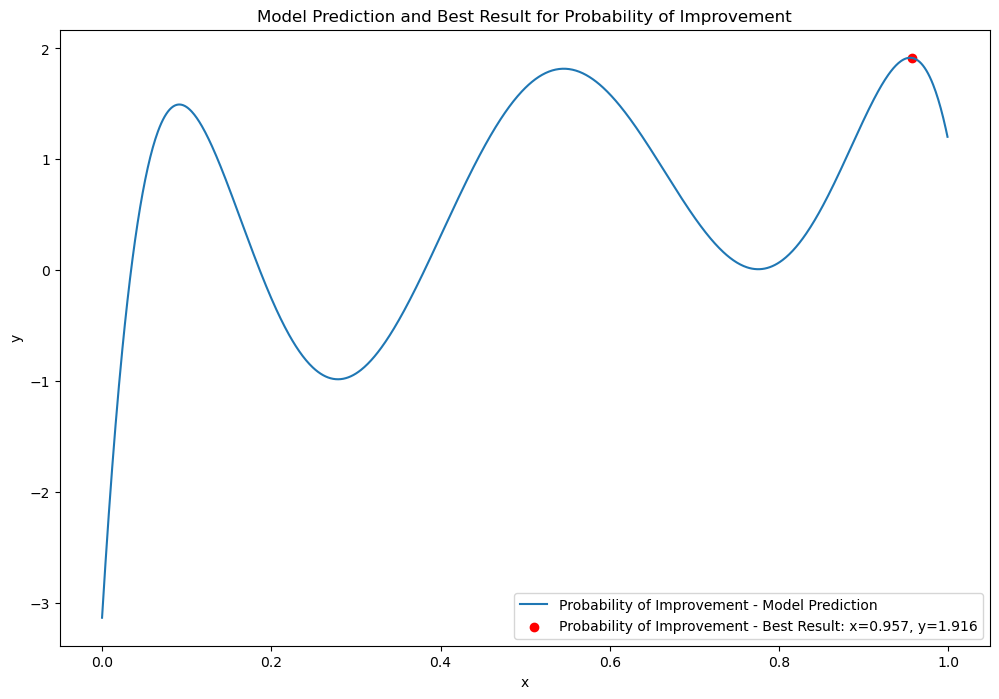

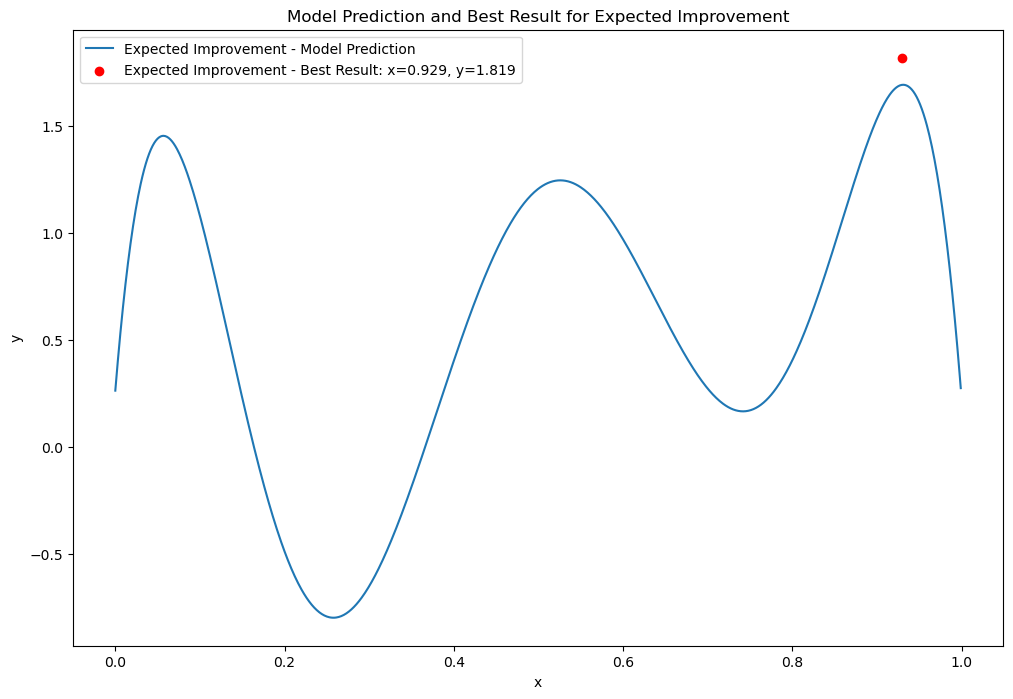

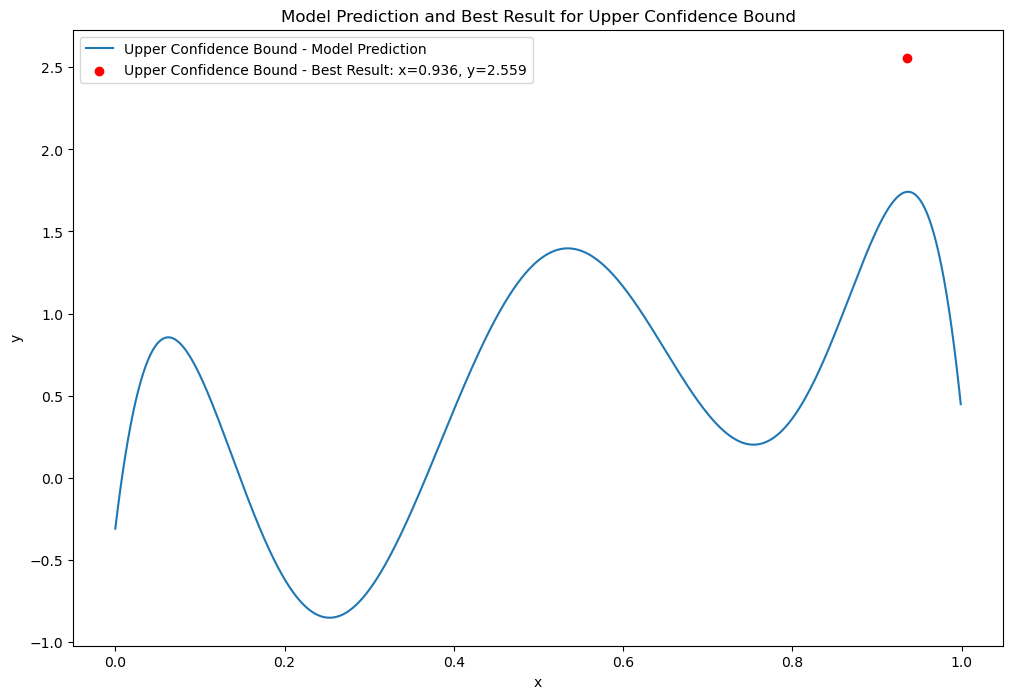

In [12]:
# Define acquisition functions
acquisition_functions = {
    'Probability of Improvement': probability_of_improvement,
    'Expected Improvement': expected_improvement,
    'Upper Confidence Bound': upper_confidence_bound
}

results = {}
models = []

# Run optimization loop for each acquisition loops
for name, acquisition_function in acquisition_functions.items():
    X_temp, y_temp = X.copy(), y.copy()
    gp_model_temp = GaussianProcessRegressor()
    gp_model_temp.fit(X_temp, y_temp)
    
    for i in range(10):
        next_sample = optimize_acquisition(X_temp, y_temp, gp_model_temp, acquisition_function)
        actual_value = objective(next_sample)
        
        # Update dataset with new sample point and observation
        X_temp = np.vstack((X_temp, [[next_sample]]))
        y_temp = np.vstack((y_temp, [[actual_value]]))
        
        # Re-fit model with updated data
        gp_model_temp.fit(X_temp, y_temp)
    
    # Store the best result for this acquisition function
    best_index = np.argmax(y_temp)
    results[name] = (X_temp[best_index], y_temp[best_index])
    
    plt.figure(figsize=(12, 8))
    Xsamples = np.arange(0, 1, 0.001).reshape(-1, 1)
    ysamples, _ = gp_model_temp.predict(Xsamples, return_std=True)
    plt.plot(Xsamples, ysamples, label=f'{name} - Model Prediction')
    plt.scatter(X_temp[best_index], y_temp[best_index], color='red', label=f"{name} - Best Result: x={X_temp[best_index][0]:.3f}, y={y_temp[best_index][0]:.3f}")
    plt.title(f'Model Prediction and Best Result for {name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

#### Sources
- [Martin Krasser](https://krasserm.github.io/2018/03/21/bayesian-optimization/)
- [Gaussian Processes for Dummies](https://katbailey.github.io/post/gaussian-processes-for-dummies/)

## Part 2: A Demonstration of Bayesian Hyperparameter Optimization

### Load the Data

In [13]:
# Create a load data function
def load_images(folder_name):
    names = []
    images = []
    for filename in os.listdir(folder_name):
        try:
            filepath = os.path.join(folder_name, filename)
            img = Image.open(filepath)
            img = img.resize((64, 64))
            img = np.asarray(img).flatten()
            names.append(filename.split(".")[0])
            images.append(img)
        except Exception as error:
            print(f"Error loading {folder_name}: {error}")
    return dict(zip(names, images)) # Returns a dictionary of names to image data

In [14]:
# Clean the data
image_data = "images"
pokemon_data = pd.read_csv("pokemon.csv")
names_to_images = load_images(image_data)

# Add image data column using dictionary and the "Name" column in the dataframe
pokemon_data['Image_Data'] = pokemon_data['Name'].map(names_to_images)
pokemon_data = pokemon_data.loc[lambda x: x.Type2.isnull()]
pokemon_data.drop('Type2', axis=1, inplace=True)  # Remove multi-type Pokémon
pokemon_data.drop('Evolution', axis=1, inplace=True)

# Filter out types with less than 30 counts
type_counts = pokemon_data['Type1'].value_counts()
valid_types = type_counts[type_counts >= 30].index
pokemon_data = pokemon_data[pokemon_data['Type1'].isin(valid_types)]

# Encode the type variable
pokemon_data['Type1'] = pokemon_data['Type1'].astype('category')
pokemon_data['Type'] = pokemon_data['Type1'].cat.codes
features = pokemon_data['Image_Data']
labels = pokemon_data['Type']

# Convert features to an array
features_list = features.tolist()
# Stack arrays into 2D numpy array
X = np.stack(features_list)
# Also convert labels into a numpy array
y = labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (171, 16384)
y_train shape: (171,)


### Create a Training Function

In [15]:
# Error function
def my_error_metric(classifier, train_features, train_labels, test_features, test_labels):
    yhat_train = classifier.predict(train_features)
    train_ac = np.mean(yhat_train == train_labels)  # Using np.mean for vectorized operation
    yhat_test = classifier.predict(test_features)
    test_ac = np.mean(yhat_test == test_labels)  # Using np.mean for vectorized operation
    return train_ac, test_ac

# Training function
def train_model_objective_func(hidden_layer_size, activation_function_ind, alpha_ind):
    activation_functions = ['identity', 'logistic', 'tanh', 'relu']
    alphas = np.logspace(0, 1, 100)
    activation_function = activation_functions[activation_function_ind]
    alpha = alphas[alpha_ind]
    model = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size,), 
                          activation=activation_function, 
                          alpha=alpha)
    model.fit(X_train, y_train)
    return my_error_metric(model, X_train, y_train, X_test, y_test)[1], (hidden_layer_size, activation_function_ind, alpha_ind)


### Hyperparameter Optimization

In [16]:
def generate_sample():
    activation_functions = ['identity', 'logistic', 'tanh', 'relu']
    alphas = np.logspace(0, 1, 100)
    neuron_size = np.random.randint(1, 2501)
    acquisition_function = np.random.randint(0, len(activation_functions))
    alpha = np.random.randint(0, len(alphas))
    return neuron_size, acquisition_function, alpha


# define an acquisition function
def choose_acquisition(X, model):
    # Generate random samples for exploration
    samples = np.array([generate_sample() for _ in range(1000)])
    # Evaluate acquisition scores for each sample
    scores = upper_confidence_bound(X, samples, model)
    # Identify the sample with the highest score
    best_index = np.argmax(scores)
    return Xsamples[best_index]

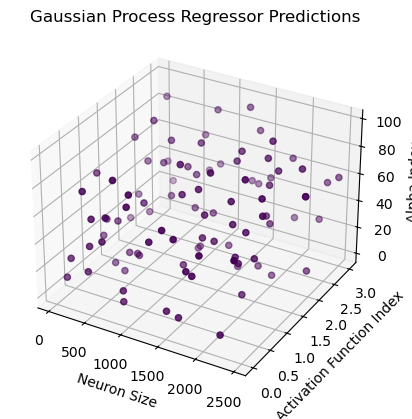

In [ ]:
def visualize_3d(title, model):  # Create a 3D plot of the Gaussian Process Regressor
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Prepare data for plotting
    X_plot = np.array([generate_sample() for _ in range(100)])
    y_plot = model.predict(X_plot)

    # Extract the individual components for plotting
    neuron_sizes = X_plot[:, 0]
    activation_functions = X_plot[:, 1]
    alphas = X_plot[:, 2]

    # Plot the surface
    ax.scatter(neuron_sizes, activation_functions, alphas, c=y_plot, cmap='viridis')
    ax.set_xlabel('Neuron Size')
    ax.set_ylabel('Activation Function Index')
    ax.set_zlabel('Alpha Index')
    ax.set_title(title)

    plt.show()

In [ ]:
pokemon_model_gp = GaussianProcessRegressor()

X = np.array([generate_sample() for _ in tqdm(range(10))])
y = [train_model_objective_func(*sample)[0] for sample in X]
pokemon_model_gp.fit(X, y)

visualize_3d("Initial Predictions", pokemon_model_gp)

In [ ]:
for i in range(50):
    sample = choose_acquisition(X, pokemon_model_gp)
    np.append(X, sample)
    np.append(train_model_objective_func(*sample)[0], y)
    pokemon_model_gp.fit(X, y)

best_ind = np.argmax(y)
print(f"Best Acquisition: {(X[best_ind], y[best_ind])}")